# Coronavirus Dataset Analysis

Reference: <br>
Updated COVID-19 Dataset: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML # display media control overlay of bar chart race
from tqdm import tqdm # show progress bar during loops
%matplotlib inline

In [2]:
# load in dataset
# this is a good dataset that broke down the time stamps into M/D/Y
# It also has 11341 data points for all countries affected by COVID-19
# there are not as many states as countries so there are null values
df = pd.read_csv('covid_19_data_to_4_5.csv')
print(df.info()) 
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12249 entries, 0 to 12248
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              12249 non-null  int64  
 1   ObservationDate  12249 non-null  object 
 2   Province/State   6407 non-null   object 
 3   Country/Region   12249 non-null  object 
 4   Last Update      12249 non-null  object 
 5   Confirmed        12249 non-null  float64
 6   Deaths           12249 non-null  float64
 7   Recovered        12249 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 765.7+ KB
None


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0


## Clean Data First

#### I like to lower case and add underscores to my column names for easier access


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ', '_') for x in df.columns]
df.columns

Index(['sno', 'observationdate', 'province/state', 'country/region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

#### turn float to integer values as there cannot be a "4.5" confirmed sick person. This data must be discrete.

In [4]:
df['confirmed'] = df['confirmed'].apply(lambda x: int(x))

# do the same for deaths and recovered
df['deaths'] = df['deaths'].apply(lambda x: int(x))
df['recovered'] = df['recovered'].apply(lambda x: int(x))

# show what results looks like
df['confirmed'].head(3)

0     1
1    14
2     6
Name: confirmed, dtype: int64

#### change 'observationdate' column into datetime datatype

In [5]:
from datetime import date
from datetime import datetime

# this code turns string '03/23/2020' to 2020-0323, which is in datetime format
print(datetime.strptime(df['observationdate'][10000], "%m/%d/%Y").date())

# make every string date into datetime format using .apply method
df['observationdate'] = df['observationdate'].apply(
    lambda x: datetime.strptime(x, "%m/%d/%Y").date())
print(f"Result: {df['observationdate'][0]}, {type(df['observationdate'][0])}")

2020-03-29
Result: 2020-01-22, <class 'datetime.date'>


#### remove any country's leading whitespace

In [6]:
df['country/region'] = df['country/region'].apply(lambda x: x.lstrip())

In [7]:
# convert datetime for interpretable string format in plot

dates = df[(df['country/region'] == 'Others') & (df['observationdate'] < date(2020,2,27))]['observationdate']
dates = list(dates.apply(lambda x: x.strftime("%b %d")))

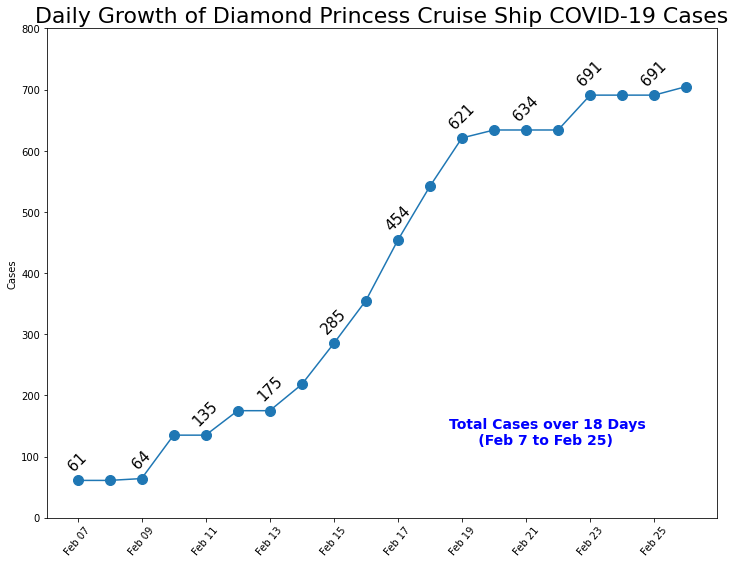

In [8]:
x = dates
y = df[(df['country/region'] == 'Others') & (df['observationdate'] < date(2020,2,27))]['confirmed']

plt.figure(figsize=(12,9))

# plt.plot(x, y)
plt.plot(x, y, marker='o', markersize= 10)

# plt.plot(x, y, marker='X', markersize= 10, color='green',mfc='red')
plt.ylabel('Cases')
plt.xlabel(' ')
plt.xticks(np.arange(0, len(dates), step=2),rotation=50)
plt.yticks(np.arange(0,820, step=100))
plt.annotate('Total Cases over 18 Days\n      (Feb 7 to Feb 25)', 
             xycoords='axes fraction', xy=[.6,.15], fontsize=14, weight=600, color='blue')

for x,y in zip(x[::2],y[::2]):

    label = "{:.0f}".format(y)
    
    plt.annotate(label, (x,y),ha='center', rotation=45, xytext=(0,10), textcoords='offset points',fontsize=15)

# plt.xticks(np.arange(0,len(dates)),labels=dates)
plt.title('Daily Growth of Diamond Princess Cruise Ship COVID-19 Cases', fontsize=22)
sns.set_context('poster')

# plt.savefig('diamondprincesscases.png')
plt.show(); # set_context allows you to choose your plot style in a practical way

In [9]:
# dropping countries and providing reasons
df = df[(df['country/region'] != 'Others') & (df['country/region'] != 'Diamond Princess')] # cruise ship not country
df= df[(df['country/region'] != 'MS Zaandam')] # another cruiseship recently confirmed, will also drop this
df = df[(df['country/region'] != 'Kosovo')] # complicated political region, pycountry unable to provide code
df = df[(df['country/region'] != 'Holy See')] # unable to find proper coding
df = df[(df['country/region'] != 'Vatican City')] # unable to find country name same as (holy see)
df = df[(df['country/region'] != 'Timor-Leste')] # code unable to access this continent code
df = df[(df['country/region'] != 'East Timor')] # (same place as Timor-Leste)
df = df[(df['country/region'] != 'Channel Islands')] # only place a part of great britain
df = df[(df['country/region'] != 'Western Sahara')]

### Calculate number of days that our data covers

In [10]:
# datetime(2019,12,31) - datetime(2019,12,31) This works!
days_since = abs((df['observationdate'].sort_values(ascending=True).head(1).item() - 
                  df['observationdate'].sort_values(ascending=False).head(1).item()).days)
days_since

74

In [11]:
# create a date time range that covers our data from beginning to last day of reported cases

beginning_date = df['observationdate'].sort_values(ascending=True).head(1).item()
print(beginning_date)
# create our range of dates
date_list = pd.date_range(beginning_date, periods=days_since+1).to_list() #days_since+1 to include last day
# snippet of what the timestamps look like
date_list[0].date()

2020-01-22


datetime.date(2020, 1, 22)

## Questions I'm Asking

### How were the Chinese provinces affected?

In [12]:
# df[(df['country/region'] == 'China') & (df['observationdate'] == date(2020,4,5))].groupby('province/state').mean().drop('sno',axis=1).sort_values(by='confirmed', ascending=False)

### How were the US states affected?

In [13]:
# df[(df['country/region'] == 'United States of America') & (df['observationdate'] == date(2020,4,5))].groupby('province/state').mean().drop('sno',axis=1).sort_values(by='confirmed', ascending=False)

### What were the least affected states?

In [14]:
# df[(df['country/region'] == 'United States of America') & (df['observationdate'] == date(2020,4,5))].groupby('province/state').mean().drop('sno',axis=1).sort_values(by='confirmed')[6:] #keep states

### What were Korea's numbers over time?

In [19]:
x = df[df['country/region'] == 'South Korea'].groupby('observationdate')['confirmed'].sum().reset_index()['observationdate']
y = df[df['country/region'] == 'South Korea'].groupby('observationdate')['confirmed'].sum().reset_index()['confirmed']

# plt.plot(x,y)

### What is flattening the curve?

In [38]:
# group all by country/region
data=df.groupby(['observationdate','country/region']).agg({'confirmed':'sum'}).reset_index()

# return dataframe with only 100 or more confirmed
data = data[data['confirmed'] >= 100]

#return the earliest date of each country where the cases are equal to 100
data = data.sort_values('observationdate')

#dataframe is sorted by earliest time with 100 or more confirmed confirmed
data = data.drop_duplicates(subset='country/region',keep='first').reset_index(drop=True)

# top 10 countries that had 100 confirmed the earliest
first_ten = data.head(10)

# the next 10 countries that reached 100 confirmed
second_ten = data.iloc[10:21]

first_ten, second_ten

(  observationdate  country/region  confirmed
 0      2020-01-22  Mainland China        547
 1      2020-02-20     South Korea        104
 2      2020-02-21           Japan        105
 3      2020-02-23           Italy        155
 4      2020-02-26            Iran        139
 5      2020-02-29          France        100
 6      2020-02-29       Singapore        102
 7      2020-03-01         Germany        130
 8      2020-03-02              US        101
 9      2020-03-02           Spain        120,
    observationdate country/region  confirmed
 10      2020-03-02      Hong Kong        100
 11      2020-03-05    Switzerland        114
 12      2020-03-05             UK        115
 13      2020-03-06         Sweden        101
 14      2020-03-06    Netherlands        128
 15      2020-03-06         Norway        108
 16      2020-03-06        Belgium        109
 17      2020-03-08        Austria        104
 18      2020-03-09       Malaysia        117
 19      2020-03-10        Denmar

In [57]:
data

,observationdate,country/region,confirmed
0,2020-01-22,Mainland China,547
1,2020-02-20,South Korea,104
2,2020-02-21,Japan,105
3,2020-02-23,Italy,155
4,2020-02-26,Iran,139
...,...,...,...
111,2020-04-03,Niger,120
112,2020-04-04,Rwanda,102
113,2020-04-04,Trinidad and Tobago,103
114,2020-04-04,Guinea,111


In [70]:
# df['first_100_date'] = df['country/region'].append(data['observationdate'])
# you want each row to start with its first date


dff = df.merge(data, on='country/region', suffixes=('','_first_100'))
# df_analysis.rename(columns={'observationdate_x' : 'first_100_date', 'observationdate_y' = d
dff

,sno,observationdate,province/state,country/region,last_update,confirmed,deaths,recovered,observationdate_first_100,confirmed_first_100
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1,0,0,2020-01-22,547
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14,0,0,2020-01-22,547
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6,0,0,2020-01-22,547
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1,0,0,2020-01-22,547
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0,0,0,2020-01-22,547
...,...,...,...,...,...,...,...,...,...,...
10639,10845,2020-04-01,NaN,West Bank and Gaza,2020-04-01 22:04:58,134,1,18,2020-03-29,109
10640,11159,2020-04-02,NaN,West Bank and Gaza,2020-04-02 23:32:01,161,1,18,2020-03-29,109
10641,11474,2020-04-03,NaN,West Bank and Gaza,2020-04-03 22:52:45,194,1,21,2020-03-29,109
10642,11789,2020-04-04,NaN,West Bank and Gaza,2020-04-04 23:41:02,217,1,21,2020-03-29,109


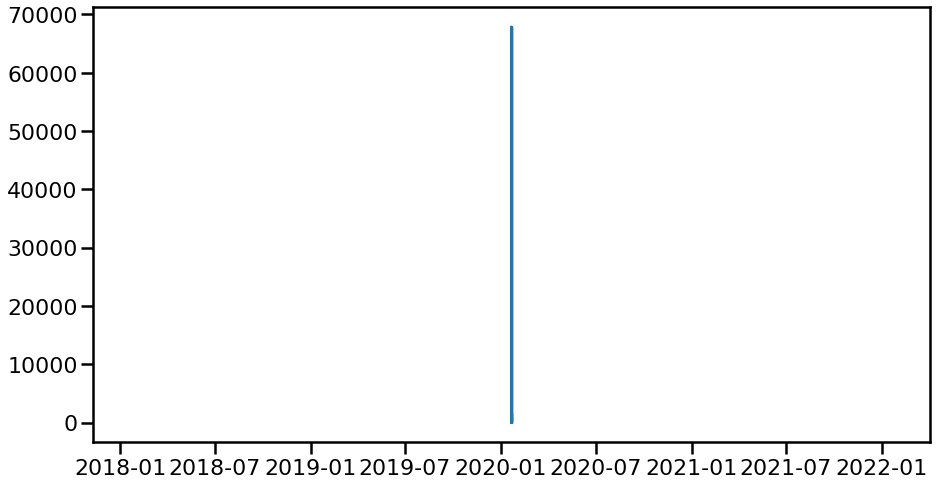

In [91]:
fig, ax = plt.subplots(figsize=(15,8))

# plot a line for each country on the figure
# plot China

x = np.arange(1,61)
y = np.arange(100,10000, step=165)


plt.plot(dff[dff['country/region']=='Mainland China']['observationdate_first_100'],dff[dff['country/region']=='Mainland China']['confirmed'])
plt.plot(dff[dff['country/region']=='United States of America']['observationdate_first_100'],)
plt.show()

# dff[dff['country/region']=='Mainland China']

In [ ]:
# group all by country/region
data=df.groupby(['observationdate','country/region']).agg({'confirmed':'sum'}).reset_index()
df.groupby(['observationdate','country/region']).agg({'confirmed':'sum'}).reset_index()

# return dataframe with only 100 or more deaths
data = data[data['confirmed'] >= 100]

#return the earliest date of each country where the cases are equal to 100
data = data.sort_values('observationdate')
#dataframe is sorted by earliest time 100 or more deaths confirmed
data = data.drop_duplicates(subset='country/region',keep='first').reset_index(drop=True)

data1 = data.loc[0:40]
data2 = data.loc[41:81]
data3 = data.loc[82:]